In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import six
sys.path.append("/Users/admin/Desktop/projects/lb_time/utils")

import sklearn.metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.grid_search import GridSearchCV
import sklearn
from sklearn.externals import joblib
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

import function
import preprocessing
import local_bayes
import visualize
import metrics

In [3]:
sys.path.append("/Users/admin/Desktop/projects/lb_time/models/cnn")
import train

# metric

In [77]:
metric = metrics.Metrics()

In [78]:
save_data_dir = '../data/bookmark/'
train_0_0 = numpy.load(save_data_dir + '0_test/0_fold/0_train.npz')
test_0_0 = numpy.load(save_data_dir + '0_test/0_fold/0_test.npz')

In [79]:
new_tr = train_0_0['x'][:1000]
new_te = test_0_0['x'][0]

In [80]:
# def min_dtw2(train, test):
    
#     min_dist_ls, min_ts_ls = numpy.array([]), []
#     te_ele = numpy.array(test).reshape(-1, 1)

#     for i, tr_ele in enumerate(train):
#         sys.stdout.write('\r%d' % i)
#         sys.stdout.flush()
#     #     tr_ele_ls = tr_ele.tolist()
#         tr_ele = numpy.array(tr_ele).reshape(-1, 1)
#         dist, path = fastdtw(te_ele, tr_ele, dist=euclidean)

#         if len(min_dist_ls) <= 10:
#             min_dist_ls = numpy.append(min_dist_ls, dist)
#             min_ts_ls.append(tr_ele_ls)
#         elif numpy.max(min_dist_ls) > dist:
#             max_ind = numpy.argmax(min_dist_ls)
#             min_dist_ls[max_ind] = dist
#             min_ts_ls[max_ind] = tr_ele_ls
#         else:
#             continue

In [81]:
# min_dtw2(train_0_0['x'][:1000], new_te)

In [104]:
localbayes = local_bayes.LocalBayes()

In [105]:
from numba.decorators import autojit
import six

In [106]:
# def min_dtw1(train, test):
#     min_dist_ls, min_ts_ls = numpy.array([]), []
#     te_ele = numpy.array(test).reshape(-1, 1)

#     for i in six.moves.range(1000):
#         sys.stdout.write('\r%d' % i)
#         sys.stdout.flush()
#     #     tr_ele_ls = tr_ele.tolist()
#         tr_ele = train[i]
#         tr_ele = numpy.array(tr_ele).reshape(-1, 1)
# #         dist, path = fastdtw(te_ele, tr_ele, dist=euclidean)

In [107]:
# min_dtw_numba = autojit(min_dtw1)

In [108]:
# min_dtw_numba(train_0_0['x'], new_te)

In [109]:
nn_dist_ls, nn_ts_ls = localbayes.get_nearest_n(train_0_0['x'], new_te)

296

In [112]:
len(nn_dist_ls)

20

In [113]:
numpy.array(nn_ts_ls)

array([[ 7,  7,  5,  2,  1,  8,  8,  5,  3,  1,  2,  2,  2,  2,  5,  2,  3,
         4,  2,  4,  2,  3,  2,  5,  0,  1,  3,  1,  1,  1],
       [ 1,  5,  2,  2,  3,  7,  3,  2,  1,  1,  2,  3,  2,  2,  1,  3,  4,
         0,  3,  0,  3,  0,  1,  1,  0,  4,  1,  1,  0,  3],
       [ 1,  5,  2,  8,  5,  3,  1,  2,  3,  0,  3,  4,  1,  2,  1,  3,  1,
         5,  6,  1,  1,  1,  1,  2,  3,  2,  5,  0,  0,  1],
       [15,  9,  6,  5,  6,  6,  2,  2,  0,  3,  3,  4,  4,  4,  3,  6,  1,
         0,  0,  3,  2,  1,  1,  1,  3,  2,  3,  2,  1,  1],
       [ 6,  2,  7,  3,  2,  1,  1,  2,  2,  3,  2,  0,  1,  2,  3,  2,  3,
         2,  4,  0,  1,  3,  0,  4,  1,  7,  3,  1,  3,  5],
       [ 2,  4,  3,  3,  4,  3,  3,  2,  2,  2,  2,  0,  2,  1,  2,  1,  0,
         2,  6,  1,  4,  2,  2,  2,  1,  2,  2,  2,  1,  2],
       [ 5,  3,  2,  1,  1,  4,  2,  1,  4,  5,  3,  2,  4,  2,  5,  2,  2,
         1,  3,  3,  5,  1,  3,  1,  1,  1,  3,  4,  2,  3],
       [10,  6,  3,  0,  1,  3,  1,  4,  

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [23]:
max_depth = 4
n_estimators = 5000

In [98]:
# bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),
#                          algorithm="SAMME",
#                          n_estimators=5000)

In [99]:
# bdt.fit(train_0_0['x'], train_0_0['y'])

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=5000, random_state=None)

In [24]:
# joblib.dump(bdt, '../models/gbdt/results/bdt_%s_%s.pkl' % (max_depth, n_estimators)) 

NameError: name 'bdt' is not defined

In [25]:
bdt = joblib.load('../models/gbdt/results/bdt_%s_%s.pkl' % (max_depth, n_estimators))

In [26]:
pred_proba = bdt.predict_proba(test_0_0['x'])
pred_proba[0:10]

array([[ 0.50418546,  0.49581454],
       [ 0.50714813,  0.49285187],
       [ 0.49450888,  0.50549112],
       [ 0.49821045,  0.50178955],
       [ 0.49816166,  0.50183834],
       [ 0.49889502,  0.50110498],
       [ 0.49458565,  0.50541435],
       [ 0.52426302,  0.47573698],
       [ 0.49845624,  0.50154376],
       [ 0.53994096,  0.46005904]])

In [31]:
test_0_0['y'][0:10]

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 0])

In [28]:
N_test = test_0_0['y'].shape[0]
miss_x, miss_y = [], []
for i in xrange(N_test):
    pred = numpy.argmax(pred_proba[i])
    if pred == test_0_0['y'][i]:
        continue 
    else:
        miss_x.append(test_0_0['x'][i])
        miss_y.append(test_0_0['y'][i])

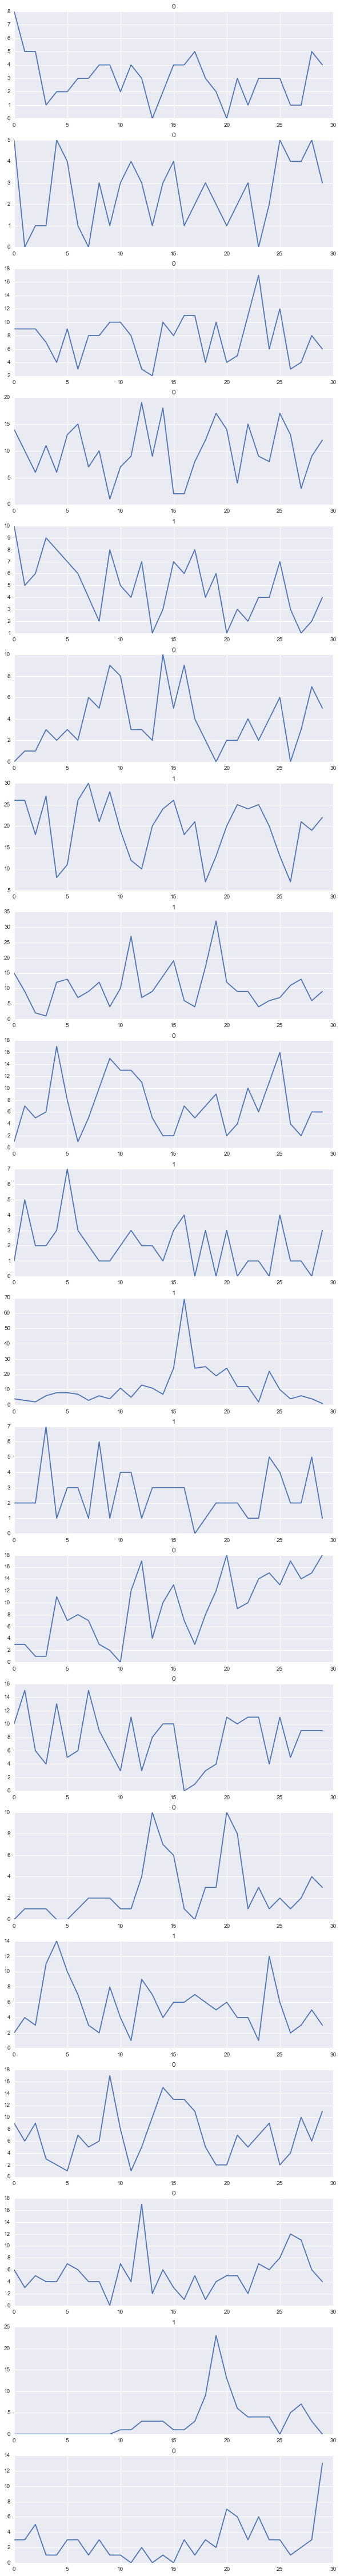

In [29]:
plt.figure(figsize=(10, 4*20), dpi=1000)
for i in xrange(20):
    plt.subplot(20, 1, i + 1)
    plt.plot(miss_x[i])
    plt.title('%s' % miss_y[i])

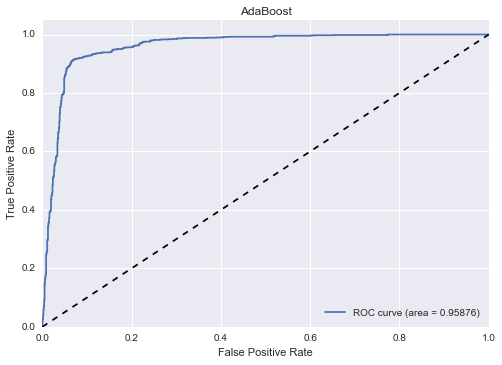

In [30]:
# Compute ROC curve and ROC area for each class
test_score = bdt.decision_function(test_0_0['x'])
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_0_0['y'], test_score)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost')
plt.legend(loc="lower right")
plt.show()

## CNN

In [33]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import optimizers
from chainer import serializers
from chainer import Link, Chain, ChainList

import pandas as pd
from ggplot import *

In [34]:
save_model_dir = '../models/cnn/results/awesome_100/'

In [35]:
sys.path.append("/Users/admin/Desktop/projects/lb_time/models/cnn")
import net

In [36]:
class tsCNN_net(chainer.Chain):

    def __init__(self, data_dim):
        self.data_dim = data_dim
        super(tsCNN_net, self).__init__(
            conv1=F.Convolution2D(1, 20, (1, 5)),
            conv2=F.Convolution2D(20, 50, (1, 5)),
            l1=L.Linear(250, 500),
            l2=L.Linear(500, 2)
            )

    def __call__(self, x):
        h1 = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h2 = F.max_pooling_2d(F.relu(self.conv2(h1)), 2)
        h3 = F.relu(self.l1(h2))
        y = self.l2(h3)
        return y

In [37]:
N_test = test_0_0['x'].shape[0]
data_dim = test_0_0['x'].shape[1]

In [38]:
model = L.Classifier(tsCNN_net(30))

In [39]:
serializers.load_npz(save_model_dir + "mlp.model", model)

In [40]:
def forward(x_data, model):
    x = chainer.Variable(x_data)
    h = F.max_pooling_2d(F.relu(model.conv1(x)), 2)
    h = F.max_pooling_2d(F.relu(model.conv2(h)), 2)
    h = F.relu(model.l1(h))
    y = model.l2(h)

    return y

In [41]:
test_0_0['x'].shape

(2378, 30)

In [42]:
X_test = test_0_0['x'].reshape((N_test, 1, 1, data_dim))
y_test = test_0_0['y']
pred_ = []
for i in range(0, N_test):
    x = np.asarray(X_test[i]).reshape((1, 1, 1, data_dim)).astype(numpy.float32)
    y = np.asarray(y_test[i]).astype(numpy.int32)
    
    pred = F.softmax(model.predictor(chainer.Variable(x)))
    pred_.append(pred.data[0][1])

In [43]:
pred_[0:10]

[7.440859e-08,
 1.9538052e-07,
 1.0,
 0.99544889,
 0.99741024,
 0.89813262,
 0.99999499,
 0.0,
 0.99734312,
 0.0]

In [44]:
y_test[0:10]

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 0])

In [85]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, numpy.array(pred_))

/Users/admin/Desktop/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


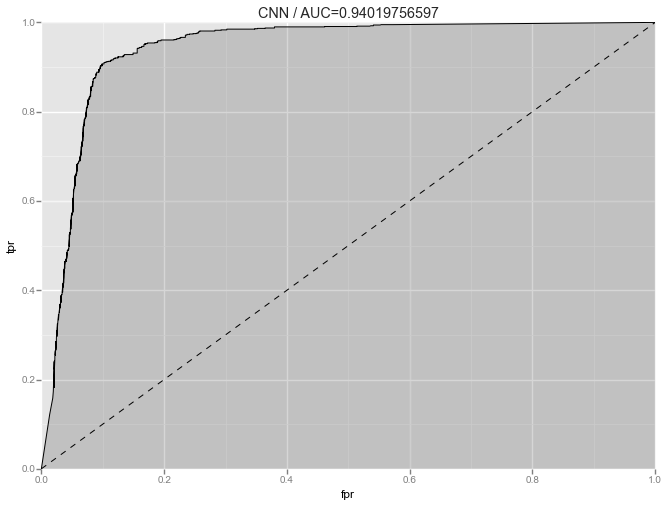

<ggplot: (283557233)>

In [86]:
auc = sklearn.metrics.auc(fpr,tpr)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', ymin=0, ymax='tpr')) +\
    geom_area(alpha=0.2) +\
    geom_line(aes(y='tpr')) +\
    geom_abline(linetype='dashed') +\
    ggtitle("CNN / AUC=%s" % str(auc))

In [45]:
import pulp

In [46]:
problem = pulp.LpProblem('localbayes', pulp.LpMaximize) # 最大化する場合

In [47]:
var = pulp.LpVariable.dicts('w', ([1,2]), 0, 1, 'Continuous')

In [48]:
var

{1: w_1, 2: w_2}

In [58]:
pred_proba[0][1]

0.49581454181672119

In [55]:
pred_[:20]

[7.440859e-08,
 1.9538052e-07,
 1.0,
 0.99544889,
 0.99741024,
 0.89813262,
 0.99999499,
 0.0,
 0.99734312,
 0.0,
 0.15330397,
 0.9999994,
 9.9162005e-31,
 1.7437933e-05,
 0.99999321,
 0.0,
 0.99999797,
 0.00027122418,
 0.1005516,
 4.9151839e-11]

In [67]:
for i in six.moves.range(20):
    cnn = pred_[i] + 0.0000001
    gbdt = pred_proba[i][1]
    model_sum = var[1] * math.log(cnn) + var[2] * math.log(gbdt)
    problem += model_sum
problem += var[1] >= 0
problem += var[2] >= 0
problem += var[1] + var[2] == 1

In [68]:
problem

localbayes:
MAXIMIZE
-16.1176042533*w_1 + -0.699505407252*w_2 + -0.0
SUBJECT TO
_C1: w_1 >= 0

_C2: w_2 >= 0

_C3: w_1 + w_2 = 1

VARIABLES
w_1 <= 1 Continuous
w_2 <= 1 Continuous

In [69]:
status = problem.solve()

In [71]:
pulp.LpStatus[status]

'Optimal'

In [72]:
var[1].value()

0.0

In [73]:
var[2].value()

1.0

### generate prediction of nn train point

In [127]:
n = 20
data_dim = len(nn_ts_ls[0])
nn_ts_array = numpy.array(nn_ts_ls).reshape((n, 1, 1, data_dim))
pred_cnn = []

for i in six.moves.range(n):
    x = np.asarray(nn_ts_array[i]).reshape((1, 1, 1, data_dim)).astype(numpy.float32)
    
    pred = F.softmax(model.predictor(chainer.Variable(x)))
    pred_cnn.append(pred.data[0][1])
    
pred_cnn = numpy.array(pred_cnn)
pred_gbdt = bdt.predict_proba(nn_ts_array.reshape(20, 30))[:, 1].astype(float32)

In [128]:
pred_cnn

array([  9.99988079e-01,   9.99928474e-01,   9.98474538e-01,
         6.80340047e-04,   9.99838948e-01,   9.99916911e-01,
         9.98352885e-01,   9.99886036e-01,   9.99996543e-01,
         9.99998808e-01,   1.77823881e-06,   8.33334343e-04,
         9.99953866e-01,   6.94811490e-07,   1.60206982e-03,
         9.99981165e-01,   9.78350818e-01,   2.32334484e-34,
         2.76201645e-05,   9.99780357e-01], dtype=float32)

In [129]:
pred_gbdt

array([ 0.50223386,  0.49973291,  0.50187421,  0.49409854,  0.50157022,
        0.50104266,  0.50086457,  0.5019697 ,  0.50106883,  0.502235  ,
        0.49648082,  0.49746409,  0.50287098,  0.49303561,  0.49671853,
        0.5024246 ,  0.50144929,  0.48345795,  0.49292389,  0.50001854], dtype=float32)

In [ ]:
learner_name = ['cnn', 'gbdt']

In [ ]:
problem = pulp.LpProblem('localbayes', pulp.LpMaximize)
var = pulp.LpVariable.dicts('w', (learner_name_ls), 0, 1, 'Continuous')

In [ ]:
for i in six.moves.range(20):
    cnn = pred_[i] + 0.0000001
    gbdt = pred_proba[i][1]
    model_sum = var[1] * math.log(cnn) + var[2] * math.log(gbdt)
    problem += model_sum

In [ ]:
for learner in learner_name:
    problem += var[learner] >= 0

In [ ]:
for learner in learner_name:
    problem += var[learner]
problem == 1